In [ ]:
import os
from PIL import Image
import torch
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, ConcatDataset, Subset
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score
from collections import Counter

import torchvision.transforms as T
from pathlib import Path
import random
from models.vqgan import GumbelVQ
from NudeNet.nudenet import nudenet
from omegaconf import OmegaConf
import matplotlib.pyplot as plt
from utils import *
from extraction import *

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}\n")
config_path = "checkpoints/config_openimages_gumbel.yaml"
ckpt_path = "checkpoints/check_openimages_gumbel.ckpt"

# Upload configuration
config = OmegaConf.load(config_path)

# Create model
model = GumbelVQ(**config['model']['params'])

# Upload weights
checkpoint = torch.load(ckpt_path, map_location=device)
model.load_state_dict(checkpoint["state_dict"], strict=False)

model = model.to(device).eval()

print("\nVQGAN loaded successfully!")
detector = nudenet.NudeDetector()
print("NudeNet loaded successfully!")

Using device: cuda

Working with z of shape (1, 256, 32, 32) = 262144 dimensions.


/tmp/ipykernel_485297/2035192655.py:13: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(ckpt_path, map_location=device)



VQGAN loaded successfully!
NudeNet loaded successfully!


# Compute forget codes using ImageNet, OpenImage and clothes folder images retain set

In [ ]:
index_codes_porn = torch.load('/home/giorgiot/taming-transformers/index_codes_porn.pt')

index_codes_retain_imagenet = torch.load('/home/gabric/VQ-GAN/index_codes_retain_imagenet.pt')
index_codes_retain_bikini = torch.load("/home/giorgiot/taming-transformers/index_codes_retain_bikini.pt")
index_codes_retain_people = torch.load("/home/giorgiot/taming-transformers/index_codes_retain_people.pt")

index_codes_retain = torch.cat([index_codes_retain_imagenet, index_codes_retain_bikini, index_codes_retain_people], dim=0)

In [ ]:
explicit_codes, scores = compute_explicit_codes(index_codes_porn, index_codes_retain, K=8192)

In [ ]:
import matplotlib.pyplot as plt
import torch

# Load image
image_path = r'/media/pinas/datasets/nsfw_images_scraped/data/test/porn/b02c8d082eff51b9a4095c245a567bc7ee20c9999dddb7a1dbb6af26cfeaa8c8.jpg'
x = load_image_to_tensor(image_path, image_size=256, device="cuda")

violent_codes_20  = explicit_codes[:20]
violent_codes_100 = explicit_codes[:100]

# ---- Original (no substitution) ----
with torch.no_grad():
    x_orig, _, _ = reconstruct_with_code_substitution(
        model, x,
        negative_codes=[],
        replacement_code=0
    )

# ---- First 20 codes ----
with torch.no_grad():
    x_20, _, mask_20 = reconstruct_with_code_substitution(
        model, x,
        negative_codes=violent_codes_20,
        replacement_code=0
    )

# ---- First 100 codes ----
with torch.no_grad():
    x_100, _, mask_100 = reconstruct_with_code_substitution(
        model, x,
        negative_codes=violent_codes_100,
        replacement_code=0
    )

# Convert tensors to numpy for matplotlib
img_orig = tensor_to_pil(x_orig)
img_20   = tensor_to_pil(x_20)
img_100  = tensor_to_pil(x_100)

# ---- Plot ----
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

axes[0].imshow(img_orig)
axes[0].set_title("Original image\nNo code substitution")
axes[0].axis("off")

axes[1].imshow(img_20)
axes[1].set_title(
    f"First 20 explicit codes substituted\nPixels changed: {mask_20.sum().item()}"
)
axes[1].axis("off")

axes[2].imshow(img_100)
axes[2].set_title(
    f"First 100 explicit codes substituted\nPixels changed: {mask_100.sum().item()}"
)
axes[2].axis("off")

plt.tight_layout()
plt.savefig("comparison_0_20_100_matplotlib.png", dpi=200)
plt.show()



# Retain set using masked explicit images (only for breasts)

In [3]:
index_codes_retain = torch.load('index_codes_masked_breasts.pt')
index_codes_retain[index_codes_retain>8191] = torch.zeros(1)
index_codes_porn = torch.load('/home/giorgiot/taming-transformers/index_codes_porn_train.pt')

/tmp/ipykernel_38343/1115838379.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  index_codes_retain = torch.load('index_codes_masked_breasts.pt')
/tmp/ipykernel_38343/111

In [4]:
explicit_codes, scores = compute_explicit_codes(index_codes_porn, index_codes_retain, K=250)
safe_codes = get_safe_codes(index_codes_retain, explicit_codes, min_freq=100)
mapping = generate_nearest_neighbor_map(model, explicit_codes, safe_codes, device)

Computing scores using Simple Frequency...
Mapping 250 explicit codes to 2636 safe candidates...


In [7]:
image_path = r'/media/pinas/datasets/nsfw_images_scraped/data/train/porn/ffff36f1d5b8c3b999d432c306d0580030b16f152a1dbac70baaaf5bbd66e4ad.jpg'
x = load_image_to_tensor(image_path, device=device)
x_fixed, indices, mask, z_q, z_q_modified = reconstruct_with_learned_map(model, x, detector, mapping, expand=0, min_score=0.6, device=device)

img = tensor_to_pil(x_fixed)
img.save("retain_breasts_test.png")
print(f"{mask.sum().item()} pixels replaced")

Number of latent codes changed: 27
110 pixels replaced


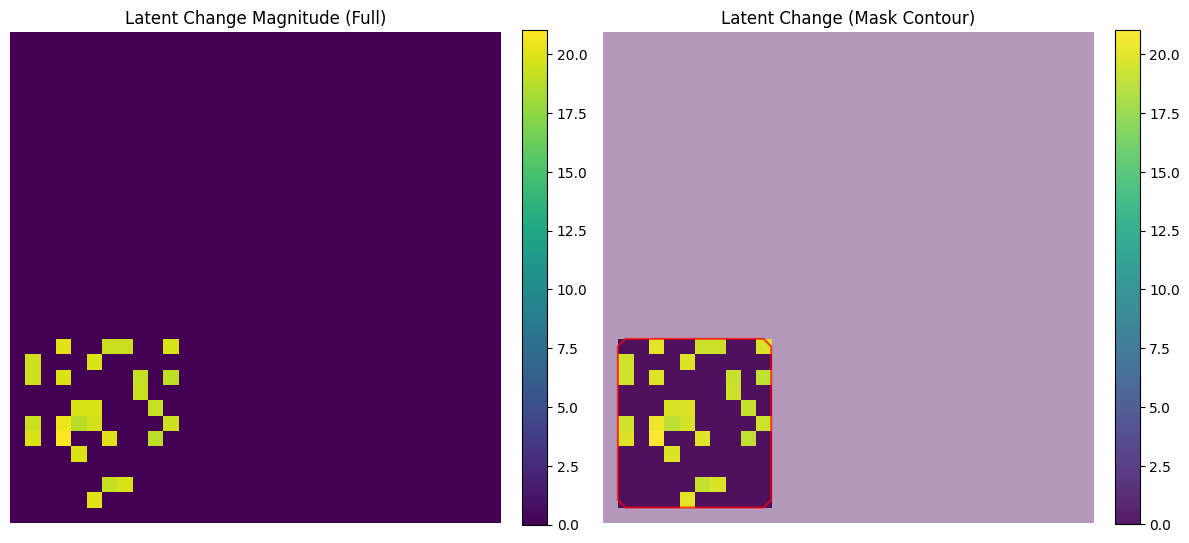

In [8]:
# Compute per-location L2 difference in latent space
latent_diff = z_q_modified - z_q                # [1, C, H_latent, W_latent]
latent_diff_mag = torch.norm(latent_diff, dim=1)  # [1, H_latent, W_latent]

latent_diff_mag_2d = latent_diff_mag[0].detach().cpu()
mask_latent_bool = mask[0].detach().cpu().bool()

# Compute pixel-space L2 difference
pixel_diff = x_fixed - x                       # [1, 3, H_img, W_img]
pixel_diff_mag = torch.norm(pixel_diff, dim=1) # [1, H_img, W_img]
pixel_diff_mag_2d = pixel_diff_mag[0].detach().cpu()


mask_img = F.interpolate(
    mask.float().unsqueeze(1),
    size=pixel_diff_mag_2d.shape,
    mode="nearest"
)[0, 0].bool().cpu()

overlay_latent = latent_diff_mag_2d.clone()
overlay_latent_np = overlay_latent.numpy()
mask_latent_np = mask_latent_bool.numpy()
overlay_latent_np[~mask_latent_np] = np.nan

fig, axes = plt.subplots(1, 2, figsize=(12, 6))  # 1 row, 2 columns

# --- Latent full ---
im0 = axes[0].imshow(latent_diff_mag_2d, cmap="viridis")
axes[0].set_title("Latent Change Magnitude (Full)")
axes[0].axis("off")
fig.colorbar(im0, ax=axes[0], fraction=0.046, pad=0.04)

# --- Latent masked overlay ---
axes[1].imshow(latent_diff_mag_2d, cmap="viridis", alpha=0.4)
im1 = axes[1].imshow(overlay_latent_np, cmap="viridis", alpha=0.9)
axes[1].contour(mask_latent_np, colors="red", linewidths=1.5, levels=[0.5], alpha=0.7)
axes[1].set_title("Latent Change (Mask Contour)")
axes[1].axis("off")
fig.colorbar(im1, ax=axes[1], fraction=0.046, pad=0.04)

plt.tight_layout()
plt.show()

# Reconstruction with a fixed random index 

In [ ]:
#image_path = r'/media/pinas/datasets/nsfw_images_scraped/data/test/porn/80cbf40eb2d4c2306b64ebe2bbd12d5b48160168c21b4f2b5bf105ebe0e8fd80.jpg'
x = load_image_to_tensor(image_path, image_size=256, device="cuda")

x_fixed, indices, mask = reconstruct_with_spatial_patching(model, x, detector, replacement_code=False, expand=0, min_score=0.5)

img = tensor_to_pil(x_fixed)
img.save("fixed_index_replacement.png")
print(f"{mask.sum().item()} pixels replaced")

Sostituiti 101 pixel


# Code Injection Test 

In [9]:
safe_img = r'/media/pinas/datasets/imagenet_zeus/val/n01494475/ILSVRC2012_val_00012879.JPEG'
explicit_img = r'/media/pinas/datasets/nsfw_images_scraped/data/test/porn/fca7e4fcb1a2b084413768b8557a3e619a4b0a0d72dbd39a88108c46b618d1b6.jpg'

x_safe = load_image_to_tensor(safe_img, image_size=256, device=device)
x_explicit = load_image_to_tensor(explicit_img, device=device, image_size=256)


x_codes_safe = model.encode(x_safe)[2][2]
x_codes_explicit = model.encode(x_explicit)[2][2]
_, _, mask, z_q, z_q_modified = reconstruct_with_spatial_patching(model, x_explicit, detector, mapping, device=device)

modified_image = inject_and_decode(model, x_codes_safe, x_codes_explicit, mask)
img = tensor_to_pil(modified_image)
z_q = model.encode(x_safe)[2][2]
z_q_modified = model.encode(modified_image)[2][2]
img.save("injected_image.png")

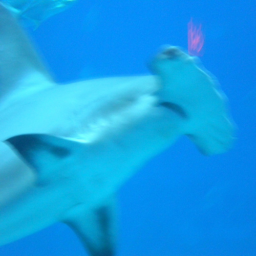

In [10]:
x_safe_img = tensor_to_pil(x_safe)
display(x_safe_img)

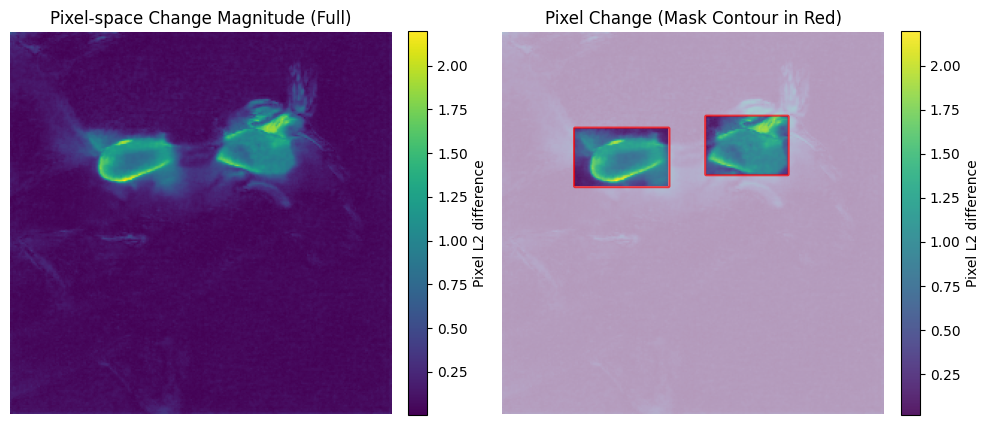

In [11]:
# Pixel-space difference
# Assuming x_fixed and x are float tensors of shape [1, 3, H_img, W_img]
pixel_diff = modified_image.detach().cpu() - x_safe.detach().cpu() # [1, 3, H_img, W_img]

# Per-pixel L2 distance across channels
pixel_diff_mag = torch.norm(pixel_diff, dim=1) # [1, H_img, W_img]

# Remove batch dimension
pixel_diff_mag_2d = pixel_diff_mag[0] # [H_img, W_img]

mask_latent = mask.float() # [1, H_latent, W_latent]

mask_img = F.interpolate(
    mask_latent.unsqueeze(1),  # [1, 1, H_latent, W_latent] (Add channel dimension)
    size=pixel_diff_mag_2d.shape, # (H_img, W_img)
    mode="nearest"
)

# Extract the boolean mask
mask_img_bool = mask_img[0, 0].bool().cpu() # [H_img, W_img]


overlay = pixel_diff_mag_2d.clone()

# Convert to numpy for np.nan assignment
overlay_np = overlay.numpy()
mask_img_np = mask_img_bool.numpy()

# Set unmasked areas to NaN
overlay_np[~mask_img_np] = np.nan


fig, axes = plt.subplots(1, 2, figsize=(10, 5))

im0 = axes[0].imshow(pixel_diff_mag_2d, cmap="viridis")
axes[0].set_title("Pixel-space Change Magnitude (Full)")
axes[0].axis("off")
fig.colorbar(im0, ax=axes[0], fraction=0.046, pad=0.04, label="Pixel L2 difference")

axes[1].imshow(pixel_diff_mag_2d, cmap="viridis", alpha=0.4)

im1 = axes[1].imshow(overlay_np, cmap="viridis", alpha=0.9)

axes[1].contour(
    mask_img_np,
    colors="red",
    linewidths=1.5,
    levels=[0.5],
    alpha=0.7
)

axes[1].set_title("Pixel Change (Mask Contour in Red)")
axes[1].axis("off")
fig.colorbar(im1, ax=axes[1], fraction=0.046, pad=0.04, label="Pixel L2 difference")

plt.tight_layout()
plt.show()

In [ ]:
indices_orig = z_q
indices_mod  = z_q_modified

# Flatten
flat_orig = indices_orig.view(-1)
flat_mod  = indices_mod.view(-1)

# Lookup embeddings
emb_orig = model.quantize.embed(flat_orig)
emb_mod  = model.quantize.embed(flat_mod)

# Reshape to latent grids: [1, C, H_latent, W_latent]
C = emb_orig.shape[-1]
H_latent, W_latent = indices_orig.shape[1], indices_orig.shape[2]

z_q_emb = emb_orig.view(1, H_latent, W_latent, C).permute(0, 3, 1, 2)
z_q_emb_mod = emb_mod.view(1, H_latent, W_latent, C).permute(0, 3, 1, 2)

latent_diff = z_q_emb_mod - z_q_emb                 # [1, C, H, W]
latent_diff_mag = torch.norm(latent_diff, dim=1)    # [1, H, W]

latent_diff_mag_2d = latent_diff_mag[0].detach().cpu()
mask_latent_bool = mask[0].detach().cpu().bool()

overlay = latent_diff_mag_2d.clone()
overlay_np = overlay.numpy()
mask_np = mask_latent_bool.numpy()

overlay_np[~mask_np] = np.nan

fig, axes = plt.subplots(1, 2, figsize=(10, 5))

im0 = axes[0].imshow(latent_diff_mag_2d, cmap="RdPu")
axes[0].set_title("Latent-space Change Magnitude (Full)")
axes[0].axis("off")
fig.colorbar(im0, ax=axes[0], fraction=0.046, pad=0.04)

axes[1].imshow(latent_diff_mag_2d, cmap="RdPu", alpha=0.4)
im1 = axes[1].imshow(overlay_np, cmap="RdPu", alpha=0.9)

axes[1].contour(
    mask_np,
    colors="red",
    linewidths=1.5,
    levels=[0.5],
    alpha=0.7
)

axes[1].set_title("Latent Change (Mask Contour)")
axes[1].axis("off")
fig.colorbar(im1, ax=axes[1], fraction=0.046, pad=0.04)

plt.tight_layout()
plt.show()

# Analysis of the codes under the explicit masks

In [ ]:
folder = "/media/pinas/datasets/nsfw_images_scraped/data/test/porn"
device = 'cuda'

linear, grid, meta = batch_extract_masked_codes(
    model=model,
    img_folder=folder,
    device='cuda',
    max_images=None
)

background = extract_codes_from_whole_images(model, folder, device, max_images=None)

analyzer = VQGANCodeAnalyzer(
    all_codes_linear=linear,
    all_codes_masked_grid=grid,  
    codebook_size=8192
)

results = analyzer.run_full_analysis(
    background_codes=background, 
    use_spatial=True,             
    use_weighted_similarity=True  
)


Processando 1000 immagini...


Estrazione codici: 100%|██████████| 1000/1000 [09:04<00:00,  1.84it/s]



Totale maschere processate: 864
Totale immagini con maschere: 504
Estrazione background da 1000 immagini


Background VQGAN: 100%|██████████| 1000/1000 [15:55<00:00,  1.05it/s]


✅ Background estratto:
   • Codici totali: 13789873
   • Immagini processate: 1000
Inizializzato analyzer con 276909 codici totali
da 864 maschere diverse
Dati spaziali disponibili per analisi co-occorrenze


ANALISI COMPLETA VQGAN
ANALISI FREQUENZA CODICI

Statistiche Generali:
 Codici totali: 276909
 Codici unici: 2886
 Copertura codebook: 35.23%
 Codici inutilizzati: 5306

Top 50 Codici più Frequenti:
Rank   Codice     Freq       %          Cum %     
------------------------------------------------------------
1      6519       936          0.34%   0.34%
2      4364       880          0.32%   0.66%
3      5860       878          0.32%   0.97%
4      1362       735          0.27%   1.24%
5      7129       724          0.26%   1.50%
6      372        719          0.26%   1.76%
7      3719       703          0.25%   2.01%
8      2724       667          0.24%   2.25%
9      6226       662          0.24%   2.49%
10     3504       660          0.24%   2.73%
11     4309       650         

# 🚧 Work in progress 🚧

## Classification Approach

In [ ]:
index_codes_porn_2D = index_codes_porn.reshape(-1, 32, 32)
index_codes_retain_2D = index_codes_retain.reshape(-1, 32, 32)

In [ ]:
explicit_ds = CodeTensorDataset(index_codes_porn_2D, label=1)
safe_ds   = CodeTensorDataset(index_codes_retain_2D, label=0)

dataset = ConcatDataset([explicit_ds, safe_ds])

In [ ]:
from collections import Counter
counts = Counter(int(dataset[i]['label']) for i in range(len(dataset)))
print(counts)



Counter({0: 125031, 1: 55078})


In [ ]:
labels = [int(dataset[i]['label']) for i in range(len(dataset))]
indices = list(range(len(dataset)))

train_idx, temp_idx, y_train, y_temp = train_test_split(
    indices, labels, test_size=0.3, stratify=labels, random_state=42
)

val_idx, test_idx, y_val, y_test = train_test_split(
    temp_idx, y_temp, test_size=0.5, stratify=y_temp, random_state=42
)

train_dataset = Subset(dataset, train_idx)
val_dataset   = Subset(dataset, val_idx)
test_dataset  = Subset(dataset, test_idx)

print("Train:", Counter([int(dataset[i]['label']) for i in train_idx]))
print("Validation:", Counter([int(dataset[i]['label']) for i in val_idx]))
print("Test:", Counter([int(dataset[i]['label']) for i in test_idx]))

train_loader = DataLoader(train_dataset,
                    batch_size=64,
                    shuffle=True,
                    num_workers=4)
val_loader = DataLoader(val_dataset,
                    batch_size=64,
                    shuffle=True,
                    num_workers=4)
test_loader = DataLoader(test_dataset,
                    batch_size=64,
                    shuffle=True,
                    num_workers=4)

Train: Counter({0: 87521, 1: 38555})
Validation: Counter({0: 18755, 1: 8261})
Test: Counter({0: 18755, 1: 8262})


### Logistic Regression

#### Train

In [ ]:
num_explicit = 55078
num_safe = 125031
pos_weight = num_safe / num_explicit

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
class_model = LogisticEmbeddingClassifier(codebook_size=8192, emb_dim=32).to(device)

criterion = nn.BCEWithLogitsLoss(pos_weight=torch.tensor(pos_weight))
optimizer = torch.optim.Adam(class_model.parameters(), lr=1e-4, weight_decay=2.5e-5)


In [ ]:
patience = 5           
best_val_loss = float('inf')
epochs_no_improve = 0
num_epochs = 20        
early_stop = False

for epoch in range(num_epochs):
    # -------- TRAIN --------
    class_model.train()
    running_loss = 0.0
    all_labels = []
    all_preds = []

    for batch in train_loader:
        codes = batch["codes"].cuda()
        labels = batch["label"].float().cuda()  # [B,1]

        
        logits = class_model(codes)
        loss = criterion(logits, labels)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item() * codes.size(0)
        all_labels.extend(labels.cpu().numpy())
        all_preds.extend(torch.sigmoid(logits).detach().cpu().numpy())

    
    train_loss = running_loss / len(train_loader.dataset)
    train_preds = [1 if p > 0.5 else 0 for p in all_preds]
    train_acc = accuracy_score(all_labels, train_preds)
    train_f1 = f1_score(all_labels, train_preds)
    train_auc = roc_auc_score(all_labels, all_preds)

    # -------- VALIDATION --------
    class_model.eval()
    val_loss = 0.0
    val_labels = []
    val_preds = []

    with torch.no_grad():
        for batch in val_loader:
            codes = batch["codes"].cuda()
            labels = batch["label"].float().cuda()  # [B,1]
            
            logits = class_model(codes)
            loss = criterion(logits, labels)
            
            val_loss += loss.item() * codes.size(0)
            val_labels.extend(labels.cpu().numpy())
            val_preds.extend(torch.sigmoid(logits).cpu().numpy())
    
    val_loss /= len(val_loader.dataset)
    val_pred_labels = [1 if p > 0.5 else 0 for p in val_preds]
    val_acc = accuracy_score(val_labels, val_pred_labels)
    val_f1 = f1_score(val_labels, val_pred_labels)
    val_auc = roc_auc_score(val_labels, val_preds)
    
    print(f"Epoch {epoch+1} | "
          f"Train loss: {train_loss:.4f}, acc: {train_acc:.4f}, f1: {train_f1:.4f}, auc: {train_auc:.4f} | "
          f"Val loss: {val_loss:.4f}, acc: {val_acc:.4f}, f1: {val_f1:.4f}, auc: {val_auc:.4f}")
    
    # -------- EARLY STOPPING --------
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        epochs_no_improve = 0
    else:
        epochs_no_improve += 1
        if epochs_no_improve >= patience:
            print("Early stopping!")
            early_stop = True
            break


Epoch 1 | Train loss: 0.6832, acc: 0.7492, f1: 0.6503, auc: 0.8406 | Val loss: 0.4707, acc: 0.8627, f1: 0.7917, auc: 0.9310
Epoch 2 | Train loss: 0.3784, acc: 0.8908, f1: 0.8334, auc: 0.9555 | Val loss: 0.4028, acc: 0.8850, f1: 0.8219, auc: 0.9490
Epoch 3 | Train loss: 0.2965, acc: 0.9165, f1: 0.8707, auc: 0.9724 | Val loss: 0.3851, acc: 0.8929, f1: 0.8329, auc: 0.9545
Epoch 4 | Train loss: 0.2505, acc: 0.9307, f1: 0.8919, auc: 0.9802 | Val loss: 0.3809, acc: 0.8999, f1: 0.8417, auc: 0.9576
Epoch 5 | Train loss: 0.2199, acc: 0.9393, f1: 0.9049, auc: 0.9846 | Val loss: 0.3800, acc: 0.9019, f1: 0.8448, auc: 0.9595
Epoch 6 | Train loss: 0.1996, acc: 0.9445, f1: 0.9129, auc: 0.9872 | Val loss: 0.3818, acc: 0.9044, f1: 0.8485, auc: 0.9608
Epoch 7 | Train loss: 0.1827, acc: 0.9490, f1: 0.9197, auc: 0.9892 | Val loss: 0.3861, acc: 0.9066, f1: 0.8516, auc: 0.9620
Epoch 8 | Train loss: 0.1672, acc: 0.9535, f1: 0.9265, auc: 0.9909 | Val loss: 0.3885, acc: 0.9098, f1: 0.8554, auc: 0.9634
Epoch 9 

In [ ]:
class_model.eval()

test_labels = []
test_preds = []

with torch.no_grad():
    for batch in test_loader:
        codes = batch["codes"].cuda()
        labels = batch["label"].float().unsqueeze(1).cuda()
        
        logits = class_model(codes)
        test_labels.extend(labels.cpu().numpy())
        test_preds.extend(torch.sigmoid(logits).cpu().numpy().flatten())

test_pred_labels = [1 if p > 0.5 else 0 for p in test_preds]
test_acc = accuracy_score(test_labels, test_pred_labels)
test_f1 = f1_score(test_labels, test_pred_labels)
test_auc = roc_auc_score(test_labels, test_preds)

print(f"TEST SET | acc: {test_acc:.4f}, f1: {test_f1:.4f}, auc: {test_auc:.4f}")


TEST SET | acc: 0.9122, f1: 0.8594, auc: 0.9646


#### Counterfactuals

In [ ]:
dataloaders = [train_loader, val_loader, test_loader]
batch_codes, batch_labels = gather_batch(dataloaders, max_images=500, device='cuda')

In [ ]:
importance_single, top_codes, importance_combinations, top_combs = codebook_counterfactual_combinations(
    class_model,
    batch_codes,
    baseline_token=0,
    topk_single=200,
    max_comb=15,
    samples_per_comb=20000,
    device='cuda',
    batch_size=16
)

print("Top 10 codici singoli più critici:")
for c in top_codes[:10]:
    print(f"Code {c} -> delta medio: {importance_single[c]:.6f}")

print("\nTop 10 combinazioni più critiche:")
for comb, delta in top_combs[:10]:
    print(f"Comb {comb} -> delta medio: {delta:.6f}")


Single code CF: 100%|██████████| 2886/2886 [01:06<00:00, 43.39it/s]



Sampling combinazioni di 2 codici...


100%|██████████| 20000/20000 [09:13<00:00, 36.11it/s]



Sampling combinazioni di 3 codici...


100%|██████████| 20000/20000 [11:56<00:00, 27.92it/s]



Sampling combinazioni di 4 codici...


100%|██████████| 20000/20000 [13:07<00:00, 25.40it/s]



Sampling combinazioni di 5 codici...


100%|██████████| 20000/20000 [14:15<00:00, 23.38it/s]



Sampling combinazioni di 6 codici...


100%|██████████| 20000/20000 [15:26<00:00, 21.58it/s]



Sampling combinazioni di 7 codici...


100%|██████████| 20000/20000 [16:14<00:00, 20.52it/s]



Sampling combinazioni di 8 codici...


100%|██████████| 20000/20000 [17:06<00:00, 19.48it/s]



Sampling combinazioni di 9 codici...


100%|██████████| 20000/20000 [18:40<00:00, 17.86it/s]



Sampling combinazioni di 10 codici...


100%|██████████| 20000/20000 [21:20<00:00, 15.61it/s]



Sampling combinazioni di 11 codici...


100%|██████████| 20000/20000 [20:45<00:00, 16.06it/s] 



Sampling combinazioni di 12 codici...


100%|██████████| 20000/20000 [21:22<00:00, 15.59it/s]



Sampling combinazioni di 13 codici...


100%|██████████| 20000/20000 [23:45<00:00, 14.03it/s]



Sampling combinazioni di 14 codici...


100%|██████████| 20000/20000 [25:42<00:00, 12.97it/s]



Sampling combinazioni di 15 codici...


100%|██████████| 20000/20000 [20:32<00:00, 16.22it/s]


Top 10 codici singoli più critici:
Code 2960 -> delta medio: 0.005852
Code 2320 -> delta medio: 0.005347
Code 3719 -> delta medio: 0.004732
Code 1565 -> delta medio: 0.004419
Code 7948 -> delta medio: 0.003989
Code 5860 -> delta medio: 0.003701
Code 4364 -> delta medio: 0.003632
Code 7459 -> delta medio: 0.003616
Code 629 -> delta medio: 0.003542
Code 7129 -> delta medio: 0.003217

Top 10 combinazioni più critiche:
Comb (4685, 4148, 5860, 4436, 1652, 7459, 2960, 11, 4311, 629, 3230, 6011, 2094, 4481) -> delta medio: 0.027669
Comb (5325, 7459, 6011, 5860, 7804, 7129, 5697, 179, 4682, 1362, 4481, 4561, 3849, 7759, 3719) -> delta medio: 0.027412
Comb (3203, 5419, 4309, 1362, 3849, 7607, 2960, 5507, 5344, 3230, 3719, 4561, 4481, 629) -> delta medio: 0.026111
Comb (5860, 4309, 7129, 3849, 2960, 21, 1565, 4067, 2866, 4481, 778, 7759, 2724) -> delta medio: 0.025727
Comb (6321, 1569, 1565, 5671, 4072, 2320, 3526, 20, 4309, 3719, 5325, 1652, 1155, 601) -> delta medio: 0.025236
Comb (629, 4075, 

In [ ]:
converted_img, p = counterfactual_grid_classifier(
    class_model,
    index_codes_retain_bikini[1].reshape(-1,32,32),
    replacement_codes=explicit_codes[:150],
    threshold=0.01,
    device="cuda"
)


=== Immagine 0 ===
Prob iniziale classe 1 = 0.1202
✓ Applying code 3719 at (20,18) | +0.0933
 → Prob aggiornata = 0.2134
✓ Applying code 4364 at (15,14) | +0.1059
 → Prob aggiornata = 0.3193
✓ Applying code 5860 at (20,11) | +0.1695
 → Prob aggiornata = 0.4888
✓ Applying code 1310 at (21,12) | +0.1206
 → Prob aggiornata = 0.6094
✓ Classificata come classe 1!


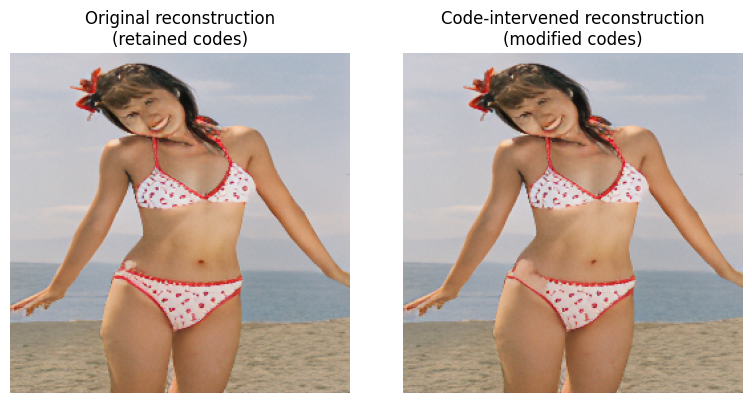

In [ ]:
with torch.no_grad():
    # Original reconstruction
    img_orig = reconstruct_from_codes(
        model,
        index_codes_retain_bikini[1].reshape(-1, 32, 32)
    )

    # Modified / intervened reconstruction
    img_intervened = reconstruct_from_codes(
        model,
        converted_img
    )

# Convert to PIL for visualization
pil_orig = tensor_to_pil(img_orig)
pil_intervened = tensor_to_pil(img_intervened)

# ---- Plot side-by-side ----
fig, axes = plt.subplots(1, 2, figsize=(8, 4))

axes[0].imshow(pil_orig)
axes[0].set_title("Original reconstruction\n(retained codes)")
axes[0].axis("off")

axes[1].imshow(pil_intervened)
axes[1].set_title("Code-intervened reconstruction\n(modified codes)")
axes[1].axis("off")

plt.tight_layout()
plt.show()


## Indices co-occurence Network 

In [ ]:
explicit_graph = build_graph_from_images([index_codes_porn_2D], neighborhood=1)
torch.save(explicit_graph, "explicit_graph.pt")

Processing images: 100%|██████████| 55078/55078 [01:48<00:00, 505.80it/s] 


In [ ]:
safe_graph = build_graph_from_images([index_codes_retain_2D], neighborhood=1)
torch.save(safe_graph, "safe_graph.pt")

Processing images: 100%|██████████| 125031/125031 [03:06<00:00, 670.09it/s] 


## Nearest Patch Replacement

In [3]:
index_codes_retain = torch.load('/home/giorgiot/taming-transformers/index_codes_retain_people.pt')
index_codes_retain = index_codes_retain.reshape(-1, 32, 32)
# print(index_codes_retain.shape)
index_codes_porn = torch.load('/home/giorgiot/taming-transformers/index_codes_porn_train.pt')
index_codes_porn = index_codes_porn.reshape(-1, 32, 32)
# print(index_codes_porn.shape)

/tmp/ipykernel_485297/2589873843.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  index_codes_retain = torch.load('/home/giorgiot/taming-transformers/index_codes_retain_p

In [9]:
patches_forget = extract_patches(index_codes_porn)
torch.save(patches_forget, 'patches_forget.pt')
print('Forget patches extracted!')

Forget patches extracted!


In [10]:
patches_retain = extract_patches(index_codes_retain)
torch.save(patches_retain, 'patches_retain.pt')
print('Forget retain extracted!')

Forget retain extracted!


In [5]:
patches_forget = torch.load('patches_forget.pt')
patches_retain = torch.load('patches_retain.pt')

/tmp/ipykernel_485297/1178291195.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  patches_forget = torch.load('patches_forget.pt')
/tmp/ipykernel_485297/1178291195.py:2: 

In [ ]:
unique_patches, scores, count_f, count_r = score_patches(
    patches_forget,
    patches_retain,
    min_freq=10
)

In [ ]:
save_dict = {
    "unique_patches": unique_patches.cpu(),
    "counts_forget": count_f.cpu(),
    "counts_retain": count_r.cpu()
    }

torch.save(save_dict, "patch_stats.pt")

In [ ]:
explicit_patches, explicit_scores = select_explicit_patches(
    unique_patches,
    scores,
    K=None,
    threshold=2.5
)

In [ ]:
retain_patch_ids = extract_patch_ids(index_codes_retain)
retain_counter = Counter(retain_patch_ids)

explicit_patch_set = set(explicit_patches)

safe_patches = [
    p for p, c in retain_counter.items()
    if c >= 20 and p not in explicit_patch_set
]

In [ ]:
patch_replacement_map = build_patch_replacement_map(model, explicit_patches, safe_patches)

In [ ]:
image_path = r'/media/pinas/datasets/nsfw_images_scraped/data/train/porn/ffff36f1d5b8c3b999d432c306d0580030b16f152a1dbac70baaaf5bbd66e4ad.jpg'
x = load_image_to_tensor(image_path, device=device)

x_unlearned, final_indices, patch_mask, _, _ = reconstruct_with_patch_unlearning(
    model=model,
    x=x,  # [1, 3, H, W]
    explicit_patch_set=set(explicit_patches),
    patch_replacement_map=patch_replacement_map,
    patch_size=3
)

img = tensor_to_pil(x_fixed)
img.save("test_patches.png")
print(f"{patch_mask.sum().item()} pixels replaced")